In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from fair_scm import *
from fair_inverse_revised import *

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
RCP85_RF = pd.read_csv('./RCP_data/RCP3PD_MIDYEAR_RADFORCING_new.csv', header=58, index_col=0)

In [9]:
num = 1000
# r_vals = np.zeros((3,num))
# beta = np.random.normal(1.0, 0.07, num)
# r_vals[0,:] = beta*32.4
# r_vals[1,:] = beta*0.019
# r_vals[2,:] = beta*4.165

d_vals = np.ones((2,num))
d_vals[0,:] = np.random.normal(239.0,63.0,num)
d_vals[1,:] = np.random.normal(4.1,1.0, num)

RWF_vals = np.random.normal(0.6,0.0915,num)
TCR_vals = np.random.lognormal(0.458, 0.279, num)
ECS_vals = TCR_vals/RWF_vals

for i in range(0,num):
    if TCR_vals[i] < 0:
        TCR_vals[i] = 0
    if ECS_vals[i] < 0:
        ECS_vals[i] = 0
        TCR_vals[i] = 0
    if d_vals[0,i] < 0:
        d_vals[0,i] = 0
    if d_vals[1,i] < 0:
        d_vals[1,i] = 0

In [10]:
# T_mean = 0

T_array = np.zeros((num,RCP85_RF.TOTAL_ANTHRO_RF.values.size))

for i in range(0,num):
    if i % 100 == 0:
        print(i)
    
    T_array[i,:] = fair_scm(other_rf=RCP85_RF.TOTAL_ANTHRO_RF.values, tcrecs=np.array([TCR_vals[i],ECS_vals[i]]), d=d_vals[:,i])[1]
    
#     plt.plot(np.arange(1765,2501), T - np.mean(T[1850-1765:1901-1765]))
    
#     T_mean += T[2100-1765]

# T_mean = T_mean/num
# print(T_mean)

0
100
200
300
400
500
600
700
800
900


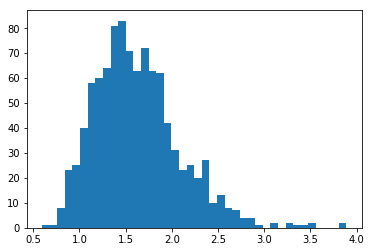

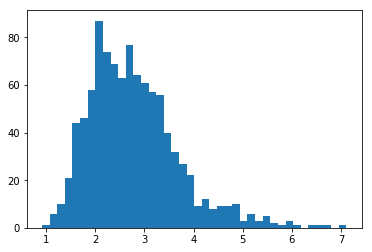

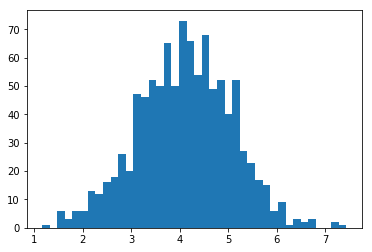

In [11]:
plt.figure()
h = plt.hist(TCR_vals, bins = 40)
plt.figure()
h = plt.hist(ECS_vals, bins = 40)
plt.figure()
h = plt.hist(d_vals[1,:], bins = 40)

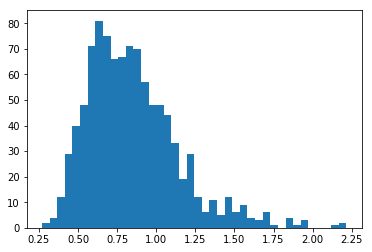

In [12]:
h=plt.hist(T_array[:,-1], bins = 40)

In [13]:
np.savetxt('1000_t_array_rcp3.txt', T_array)
np.savetxt('1000_TCR_array_rcp3.txt', TCR_vals)
np.savetxt('1000_ECS_array_rcp3.txt', ECS_vals)
np.savetxt('1000_d_array_rcp3.txt', d_vals)

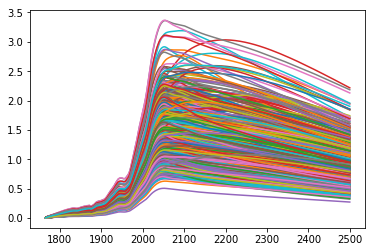

In [4]:
num = 1000

T_array_in = np.genfromtxt('1000_t_array_rcp3.txt')
TCR_array_in = np.genfromtxt('1000_TCR_array_rcp3.txt')
ECS_array_in = np.genfromtxt('1000_ECS_array_rcp3.txt')
d_array_in = np.genfromtxt('1000_d_array_rcp3.txt')

for i in range(0,num):
    plt.plot(np.arange(1765,2501), T_array_in[i,:])




In [5]:
# plt.plot(T_array_in)


# add some random noise to T_array_in for now...
for i in range(0,T_array_in.shape[1]):
    T_array_in[:,i] += np.random.normal(0,0.1,num)


# take 20 year centred mean for each timestep... 
T_array_Rolling20YrCentredMean = np.zeros_like(T_array_in)

for i in range(0,T_array_in.shape[1]):
    if i > 9 and i < T_array_in.shape[1] - 10:
        T_array_Rolling20YrCentredMean[:,i] = np.mean(T_array_in[:,i-10:i+10], axis=1) + np.random.normal(0.0,0.1,num)
    elif i == 9:
        gradient = (T_array_in[:,i] - np.mean(T_array_in[:,i:i+21], axis=1))/10
        _0_9_array = np.ones((num,10))*np.arange(-9,1)*gradient[:,np.newaxis]
        T_array_Rolling20YrCentredMean[:,0:i+1] = T_array_Rolling20YrCentredMean[:,i-1][:,np.newaxis] + _0_9_array*np.mean(T_array_in[:,i:i+20], axis=1)[:,np.newaxis]  + np.random.normal(0.0,0.1,(num,10))  
    elif i == T_array_in.shape[1] - 10:
        gradient = (np.mean(T_array_in[:,i-19:i+1], axis=1) - T_array_in[:,i-19])/10
        _1_10_array = np.ones((num,10))*np.arange(1,11)*gradient[:,np.newaxis]
        T_array_Rolling20YrCentredMean[:,i:] = T_array_Rolling20YrCentredMean[:,i-1][:,np.newaxis] + _1_10_array  + np.random.normal(0.0,0.1,(num,10))
        
        
        

# What does this mean?

We find the TCR correlates much better than ECS for equivalent of figure 1 with FaIR

So does this mean for a theoretically perfect measurement of the TCR it should act as a better predictor over all time? Unsure...

We have a number of things missing from this...

1) Noise is only added to the tenperature dataset, not the input forcing, when actaully we should really add a gaussian noise on to input forcing? maybe

2) We use the inputted TCR and ECS into the model to correlate against. Maybe we should add noise to the forcing and diagnose ECS and TCR using the procedures outline for CMIP models?



In [7]:
one_pc_yr = np.zeros(150)
for i in range(0,one_pc_yr.size):
    one_pc_yr[i] = 278.0*(1.01**i)

T_onepc = np.zeros((num,150))
for i in range(0,num):
#     T_array_in = np.genfromtxt('1000_t_array_rcp85.txt')
#     TCR_array_in = np.genfromtxt('1000_TCR_array_rcp85.txt')
#     ECS_array_in = np.genfromtxt('1000_ECS_array_rcp85.txt')
#     d_array_in = np.genfromtxt('1000_d_array_rcp85.txt')

    T = fair_scm(co2_concs=one_pc_yr, tcrecs=np.array([TCR_array_in[i], ECS_array_in[i]]), d=d_array_in[:,i])[1]
    
    T_onepc[i,:] = T # + np.random.normal(0,0.1,150)
    
# for i in range(0,150):
#     plt.plot(T_onepc[i,:])
    
TCR_vals_for_plot = np.mean(T_onepc[:,60:81], axis=1) + np.random.normal(0.0, 0.1, num)

T140_for_plot = np.mean(T_onepc[:,130:151], axis=1) + np.random.normal(0.0, 0.1, num)

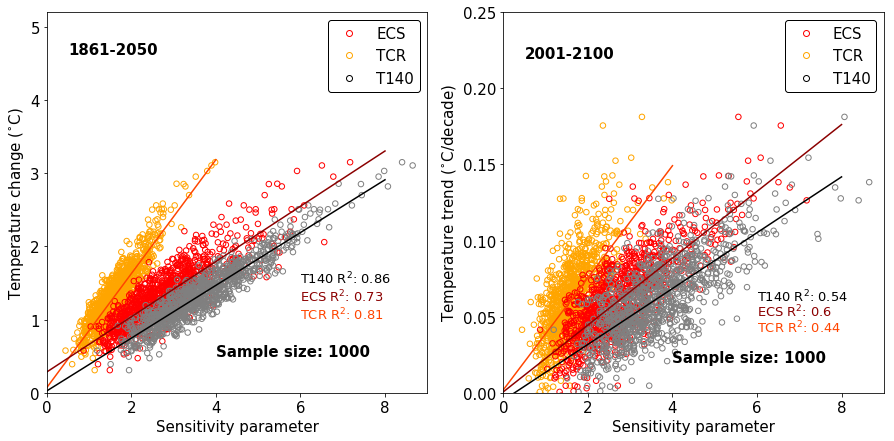

In [8]:
fig_1_n_subset,ax_1_n_subset = plt.subplots(1,2,figsize=(15,7)) 


ECS_array_in = np.genfromtxt('1000_ECS_array_rcp3.txt')
ECS_array_in += np.random.normal(0.0,0.1,num)
TCR_array_in = TCR_vals_for_plot

n_subset = 1000

T_difference_1861_2050_subset = T_array_Rolling20YrCentredMean[:n_subset,2050-1765] - T_array_Rolling20YrCentredMean[:n_subset,1861-1765]
T_difference_2001_2100_subset = T_array_Rolling20YrCentredMean[:n_subset,2100-1765] - T_array_Rolling20YrCentredMean[:n_subset,2001-1765]



def fit_line(x,a,b):
    return a*x + b
    
popt1, pcov1 = curve_fit(fit_line, TCR_array_in[:n_subset], T_difference_1861_2050_subset)
popt2, pcov2 = curve_fit(fit_line, TCR_array_in[:n_subset], T_difference_2001_2100_subset/10)
popt3, pcov3 = curve_fit(fit_line, ECS_array_in[:n_subset], T_difference_1861_2050_subset)
popt4, pcov4 = curve_fit(fit_line, ECS_array_in[:n_subset], T_difference_2001_2100_subset/10)

popt5, pcov5 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_1861_2050_subset)
popt6, pcov6 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_2001_2100_subset/10)



var_total_1861_2050 = np.sum((T_difference_1861_2050_subset - np.mean(T_difference_1861_2050_subset))**2)
var_explained_1861_2050_tcr = np.sum((T_difference_1861_2050_subset - popt1[0]*TCR_array_in[:n_subset] - popt1[1])**2)
var_explained_1861_2050_ecs = np.sum((T_difference_1861_2050_subset - popt3[0]*ECS_array_in[:n_subset] - popt3[1])**2)
var_explained_1861_2050_t140 = np.sum((T_difference_1861_2050_subset - popt5[0]*T140_for_plot[:n_subset] - popt5[1])**2)
r_squared_1861_2050_tcr = 1 - (var_explained_1861_2050_tcr / var_total_1861_2050)
r_squared_1861_2050_ecs = 1 - (var_explained_1861_2050_ecs / var_total_1861_2050)
r_squared_1861_2050_t140 = 1 - (var_explained_1861_2050_t140 / var_total_1861_2050)

var_total_2001_2100 = np.sum((T_difference_2001_2100_subset/10 - np.mean(T_difference_2001_2100_subset/10))**2)
var_explained_2001_2100_tcr = np.sum((T_difference_2001_2100_subset/10 - popt2[0]*TCR_array_in[:n_subset] - popt2[1])**2)
var_explained_2001_2100_ecs = np.sum((T_difference_2001_2100_subset/10 - popt4[0]*ECS_array_in[:n_subset] - popt4[1])**2)
var_explained_2001_2100_t140 = np.sum((T_difference_2001_2100_subset/10 - popt6[0]*T140_for_plot[:n_subset] - popt6[1])**2)
r_squared_2001_2100_tcr = 1 - (var_explained_2001_2100_tcr / var_total_2001_2100)
r_squared_2001_2100_ecs = 1 - (var_explained_2001_2100_ecs / var_total_2001_2100)
r_squared_2001_2100_t140 = 1 - (var_explained_2001_2100_t140 / var_total_2001_2100)

ax_1_n_subset[0].text(6,1,'TCR R$^2$: '+str(np.round(r_squared_1861_2050_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[0].text(6,1.25,'ECS R$^2$: '+str(np.round(r_squared_1861_2050_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[0].text(6,1.5,'T140 R$^2$: '+str(np.round(r_squared_1861_2050_t140,2)), color='black', fontsize=13)

ax_1_n_subset[1].text(6,0.04,'TCR R$^2$: '+str(np.round(r_squared_2001_2100_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[1].text(6,0.05,'ECS R$^2$: '+str(np.round(r_squared_2001_2100_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[1].text(6,0.06,'T140 R$^2$: '+str(np.round(r_squared_2001_2100_t140,2)), color='black', fontsize=13)






p1 = ax_1_n_subset[0].scatter(TCR_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='orange', label='TCR')
p2 = ax_1_n_subset[1].scatter(TCR_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='orange')

p1 = ax_1_n_subset[0].scatter(ECS_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='red', label='ECS')
p2 = ax_1_n_subset[1].scatter(ECS_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='red')

p1 = ax_1_n_subset[0].scatter(T140_for_plot[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='grey', label='T140')
p2 = ax_1_n_subset[1].scatter(T140_for_plot[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='grey')

ax_1_n_subset[0].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[0].set_ylabel('Temperature change ($^{\circ}$C)',fontsize=15)
ax_1_n_subset[1].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[1].set_ylabel('Temperature trend ($^{\circ}$C/decade)',fontsize=15)
ax_1_n_subset[0].tick_params(labelsize=15)
ax_1_n_subset[1].tick_params(labelsize=15)
ax_1_n_subset[0].text(4.0,0.5,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(4.0,0.02,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[0].text(0.5,5.2*0.8/0.9,'1861-2050',fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(0.5,0.22,'2001-2100',fontsize=15,fontweight='bold')
ax_1_n_subset[0].set_xlim(0,9)
ax_1_n_subset[1].set_xlim(0,9)
ax_1_n_subset[0].set_ylim(0,5.2)
ax_1_n_subset[1].set_ylim(0,0.25)
# ax_1_n_subset[0].legend('best', edgecolor='none', framealpha=0.0)


ax_1_n_subset[0].plot(np.arange(0,5),np.arange(0,5)*popt1[0] + popt1[1], color='orangered')
ax_1_n_subset[1].plot(np.arange(0,5),np.arange(0,5)*popt2[0] + popt2[1], color='orangered')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt3[0] + popt3[1], color='darkred')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt4[0] + popt4[1], color='darkred')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt5[0] + popt5[1], color='black')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt6[0] + popt6[1], color='black')

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='red', color='none', label='ECS', markersize=6, markerfacecolor='none'),
                  Line2D([0], [0], marker='o', markeredgecolor='orange', color='none', label='TCR', markerfacecolor='none', markersize=6),
                  Line2D([0], [0], marker='o', markeredgecolor='black', color='none', label='T140', markerfacecolor='none', markersize=6)]

ax_1_n_subset[0].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)
ax_1_n_subset[1].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)



# fig_1_n_subset.savefig('tcr_t140_ecs_comparison_rsquared_RCP3PD.pdf',dpi=300)

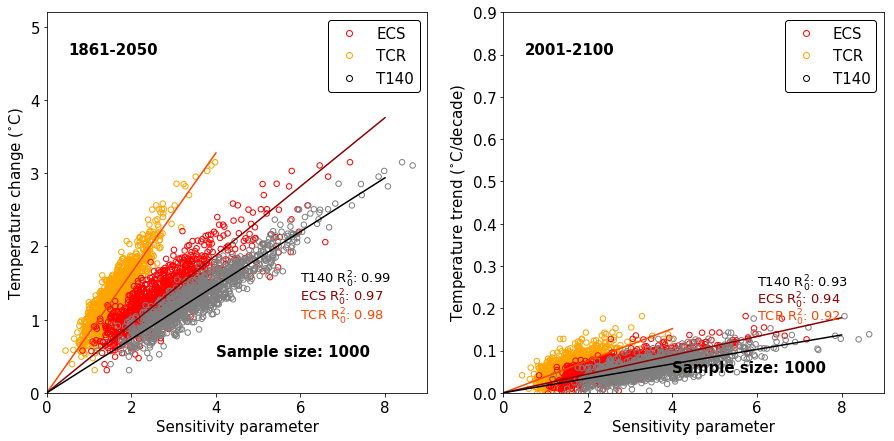

In [9]:
fig_1_n_subset,ax_1_n_subset = plt.subplots(1,2,figsize=(15,7)) 


ECS_array_in = np.genfromtxt('1000_ECS_array_rcp3.txt')
ECS_array_in += np.random.normal(0.0,0.1,num)
TCR_array_in = TCR_vals_for_plot

n_subset = 1000

T_difference_1861_2050_subset = T_array_Rolling20YrCentredMean[:n_subset,2050-1765] - T_array_Rolling20YrCentredMean[:n_subset,1861-1765]
T_difference_2001_2100_subset = T_array_Rolling20YrCentredMean[:n_subset,2100-1765] - T_array_Rolling20YrCentredMean[:n_subset,2001-1765]



def fit_line_no_intercept(x,a):
    return a*x
    
popt1, pcov1 = curve_fit(fit_line_no_intercept, TCR_array_in[:n_subset], T_difference_1861_2050_subset)
popt2, pcov2 = curve_fit(fit_line_no_intercept, TCR_array_in[:n_subset], T_difference_2001_2100_subset/10)
popt3, pcov3 = curve_fit(fit_line_no_intercept, ECS_array_in[:n_subset], T_difference_1861_2050_subset)
popt4, pcov4 = curve_fit(fit_line_no_intercept, ECS_array_in[:n_subset], T_difference_2001_2100_subset/10)

popt5, pcov5 = curve_fit(fit_line_no_intercept, T140_for_plot[:n_subset], T_difference_1861_2050_subset)
popt6, pcov6 = curve_fit(fit_line_no_intercept, T140_for_plot[:n_subset], T_difference_2001_2100_subset/10)



var_total_1861_2050 = np.sum((T_difference_1861_2050_subset)**2)
var_explained_1861_2050_tcr = np.sum((T_difference_1861_2050_subset - popt1[0]*TCR_array_in[:n_subset])**2)
var_explained_1861_2050_ecs = np.sum((T_difference_1861_2050_subset - popt3[0]*ECS_array_in[:n_subset])**2)
var_explained_1861_2050_t140 = np.sum((T_difference_1861_2050_subset - popt5[0]*T140_for_plot[:n_subset])**2)
r_squared_1861_2050_tcr = 1 - (var_explained_1861_2050_tcr / var_total_1861_2050)
r_squared_1861_2050_ecs = 1 - (var_explained_1861_2050_ecs / var_total_1861_2050)
r_squared_1861_2050_t140 = 1 - (var_explained_1861_2050_t140 / var_total_1861_2050)

var_total_2001_2100 = np.sum((T_difference_2001_2100_subset/10)**2)
var_explained_2001_2100_tcr = np.sum((T_difference_2001_2100_subset/10 - popt2[0]*TCR_array_in[:n_subset])**2)
var_explained_2001_2100_ecs = np.sum((T_difference_2001_2100_subset/10 - popt4[0]*ECS_array_in[:n_subset])**2)
var_explained_2001_2100_t140 = np.sum((T_difference_2001_2100_subset/10 - popt6[0]*T140_for_plot[:n_subset])**2)
r_squared_2001_2100_tcr = 1 - (var_explained_2001_2100_tcr / var_total_2001_2100)
r_squared_2001_2100_ecs = 1 - (var_explained_2001_2100_ecs / var_total_2001_2100)
r_squared_2001_2100_t140 = 1 - (var_explained_2001_2100_t140 / var_total_2001_2100)

ax_1_n_subset[0].text(6,1,'TCR R$_0^2$: '+str(np.round(r_squared_1861_2050_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[0].text(6,1.25,'ECS R$_0^2$: '+str(np.round(r_squared_1861_2050_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[0].text(6,1.5,'T140 R$_0^2$: '+str(np.round(r_squared_1861_2050_t140,2)), color='black', fontsize=13)

ax_1_n_subset[1].text(6,0.17,'TCR R$_0^2$: '+str(np.round(r_squared_2001_2100_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[1].text(6,0.21,'ECS R$_0^2$: '+str(np.round(r_squared_2001_2100_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[1].text(6,0.25,'T140 R$_0^2$: '+str(np.round(r_squared_2001_2100_t140,2)), color='black', fontsize=13)






p1 = ax_1_n_subset[0].scatter(TCR_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='orange', label='TCR')
p2 = ax_1_n_subset[1].scatter(TCR_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='orange')

p1 = ax_1_n_subset[0].scatter(ECS_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='red', label='ECS')
p2 = ax_1_n_subset[1].scatter(ECS_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='red')

p1 = ax_1_n_subset[0].scatter(T140_for_plot[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='grey', label='T140')
p2 = ax_1_n_subset[1].scatter(T140_for_plot[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='grey')

ax_1_n_subset[0].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[0].set_ylabel('Temperature change ($^{\circ}$C)',fontsize=15)
ax_1_n_subset[1].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[1].set_ylabel('Temperature trend ($^{\circ}$C/decade)',fontsize=15)
ax_1_n_subset[0].tick_params(labelsize=15)
ax_1_n_subset[1].tick_params(labelsize=15)
ax_1_n_subset[0].text(4.0,0.5,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(4.0,0.5/10,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[0].text(0.5,5.2*0.8/0.9,'1861-2050',fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(0.5,0.8,'2001-2100',fontsize=15,fontweight='bold')
ax_1_n_subset[0].set_xlim(0,9)
ax_1_n_subset[1].set_xlim(0,9)
ax_1_n_subset[0].set_ylim(0,5.2)
ax_1_n_subset[1].set_ylim(0,0.9)
# ax_1_n_subset[0].legend('best', edgecolor='none', framealpha=0.0)


ax_1_n_subset[0].plot(np.arange(0,5),np.arange(0,5)*popt1[0], color='orangered')
ax_1_n_subset[1].plot(np.arange(0,5),np.arange(0,5)*popt2[0], color='orangered')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt3[0], color='darkred')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt4[0], color='darkred')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt5[0], color='black')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt6[0], color='black')

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='red', color='none', label='ECS', markersize=6, markerfacecolor='none'),
                  Line2D([0], [0], marker='o', markeredgecolor='orange', color='none', label='TCR', markerfacecolor='none', markersize=6),
                  Line2D([0], [0], marker='o', markeredgecolor='black', color='none', label='T140', markerfacecolor='none', markersize=6)]

ax_1_n_subset[0].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)
ax_1_n_subset[1].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)



# fig_1_n_subset.savefig('tcr_t140_ecs_comparison_rsquared0.pdf',dpi=300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


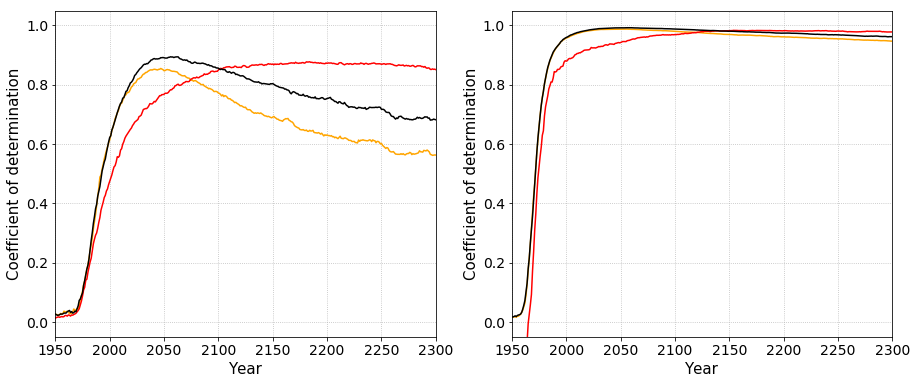

In [10]:
fig_r2, ax_r2 = plt.subplots(1,2,figsize=(15,6))    

ax_r2[0].set_xlabel('Year', fontsize=15)
ax_r2[0].set_ylabel('Coefficient of determination', fontsize=15)
ax_r2[0].tick_params(labelsize=14)
# ax_r2[0].legend(loc='lower right', framealpha = 1.0, edgecolor='black', fontsize=13)
ax_r2[0].grid(True, linestyle=':', alpha=0.9)
ax_r2[0].set_xlim(1950,2300)
ax_r2[0].set_ylim(-0.05,1.05)

ax_r2[1].set_xlabel('Year', fontsize=15)
ax_r2[1].set_ylabel('Coefficient of determination', fontsize=15)
ax_r2[1].tick_params(labelsize=14)
# ax_r2[1].legend(loc='lower right', framealpha = 1.0, edgecolor='black', fontsize=13)
ax_r2[1].grid(True, linestyle=':', alpha=0.9)
ax_r2[1].set_xlim(1950,2300)
ax_r2[1].set_ylim(-0.05,1.05)

num_runs = 50

r_TCRs = np.zeros(((2301-1800),num_runs))
r_ECSs = np.zeros(((2301-1800),num_runs))
r_T140s = np.zeros(((2301-1800),num_runs))
r_TCRs_2 = np.zeros(((2301-1800),num_runs))
r_ECSs_2 = np.zeros(((2301-1800),num_runs))
r_T140s_2 = np.zeros(((2301-1800),num_runs))

ECS_array_in = np.genfromtxt('1000_ECS_array_rcp3.txt')
ECS_array_in += np.random.normal(0.0,0.1,num)

for j in range(0,num_runs):
    print(j)
    n_subset = 25
    
    subset = np.random.randint(0, high=num, size=n_subset)

    for i in range(1800-1765,2301-1765):

        T_difference_subset = np.mean(T_array_in[subset,i-10:i+10] - T_array_in[subset,1950-1765][:,np.newaxis], axis=1)

    #     slope1, intercept1, r_TCRs[i+1765-1800], c1, d1 = linregress(TCR_vals_for_plot, y = T_difference_subset)
    #     slope3, intercept3, r_ECSs[i+1765-1800], c3, d3 = linregress(ECS_array_in, y = T_difference_subset)

        popt1, pcov1 = curve_fit(fit_line, TCR_vals_for_plot[subset], T_difference_subset)
        popt3, pcov3 = curve_fit(fit_line, ECS_array_in[subset], T_difference_subset)
        popt5, pcov5 = curve_fit(fit_line, T140_for_plot[subset], T_difference_subset)

        var_total = np.sum((T_difference_subset - np.mean(T_difference_subset))**2)
        var_explained_tcr = np.sum((T_difference_subset - popt1[0]*TCR_vals_for_plot[subset] - popt1[1])**2)
        var_explained_ecs = np.sum((T_difference_subset - popt3[0]*ECS_array_in[subset] - popt3[1])**2)
        var_explained_t140 = np.sum((T_difference_subset - popt5[0]*T140_for_plot[subset] - popt5[1])**2)
        r_TCRs[i-1800+1765, j] = 1 - (var_explained_tcr / var_total)
        r_ECSs[i-1800+1765, j] = 1 - (var_explained_ecs / var_total)
        r_T140s[i-1800+1765, j] = 1 - (var_explained_t140 / var_total)



        popt2, pcov2 = curve_fit(fit_line_no_intercept, TCR_vals_for_plot[subset], T_difference_subset)
        popt4, pcov4 = curve_fit(fit_line_no_intercept, ECS_array_in[subset], T_difference_subset)
        popt6, pcov6 = curve_fit(fit_line_no_intercept, T140_for_plot[subset], T_difference_subset)

        var_total_2 = np.sum((T_difference_subset)**2)
        var_explained_tcr_2 = np.sum((T_difference_subset - popt2[0]*TCR_vals_for_plot[subset])**2)
        var_explained_ecs_2 = np.sum((T_difference_subset - popt3[0]*ECS_array_in[subset])**2)
        var_explained_t140_2 = np.sum((T_difference_subset - popt6[0]*T140_for_plot[subset])**2)
        r_TCRs_2[i-1800+1765, j] = 1 - (var_explained_tcr_2 / var_total_2)
        r_ECSs_2[i-1800+1765, j] = 1 - (var_explained_ecs_2 / var_total_2)
        r_T140s_2[i-1800+1765, j] = 1 - (var_explained_t140_2 / var_total_2)


    
#     ax_r2[0].plot(np.arange(1800,2301), r_TCRs, color='orange', label='TCR')
#     ax_r2[0].plot(np.arange(1800,2301), r_ECSs, color='red', label='ECS')
#     ax_r2[0].plot(np.arange(1800,2301), r_T140s, color='black', label='T140')

#     ax_r2[1].plot(np.arange(1800,2301), r_TCRs_2, color='orange', label='TCR')
#     ax_r2[1].plot(np.arange(1800,2301), r_ECSs_2, color='red', label='ECS')
#     ax_r2[1].plot(np.arange(1800,2301), r_T140s_2, color='black', label='T140')
                     
ax_r2[0].plot(np.arange(1800,2301), np.median(r_TCRs, axis=1), color='orange', label='TCR')
ax_r2[0].plot(np.arange(1800,2301), np.median(r_ECSs, axis=1), color='red', label='ECS')
ax_r2[0].plot(np.arange(1800,2301), np.median(r_T140s, axis=1), color='black', label='T140')

ax_r2[1].plot(np.arange(1800,2301), np.median(r_TCRs_2, axis=1), color='orange', label='TCR')
ax_r2[1].plot(np.arange(1800,2301), np.median(r_ECSs_2, axis=1), color='red', label='ECS')
ax_r2[1].plot(np.arange(1800,2301), np.median(r_T140s_2, axis=1), color='black', label='T140')
                     
# ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_TCRs, 17, axis=1), np.percentile(r_TCRs, 83, axis=1), color='orange', label='TCR', alpha=0.3)
# ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_ECSs, 17, axis=1), np.percentile(r_ECSs, 83, axis=1), color='red', label='ECS')
# ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_T140s, 17, axis=1), np.percentile(r_T140s, 83, axis=1), color='black', label='T140')

# ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_TCRs_2, 17, axis=1), np.percentile(r_TCRs_2, 83, axis=1), color='orange', label='TCR')
# ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_ECSs_2, 17, axis=1), np.percentile(r_ECSs_2, 83, axis=1), color='red', label='ECS')
# ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_T140s_2, 17, axis=1), np.percentile(r_T140s_2, 83, axis=1), color='black', label='T140')


# fig_r2.savefig('r_squared_values.pdf', dpi=300)

(0, 1.05)

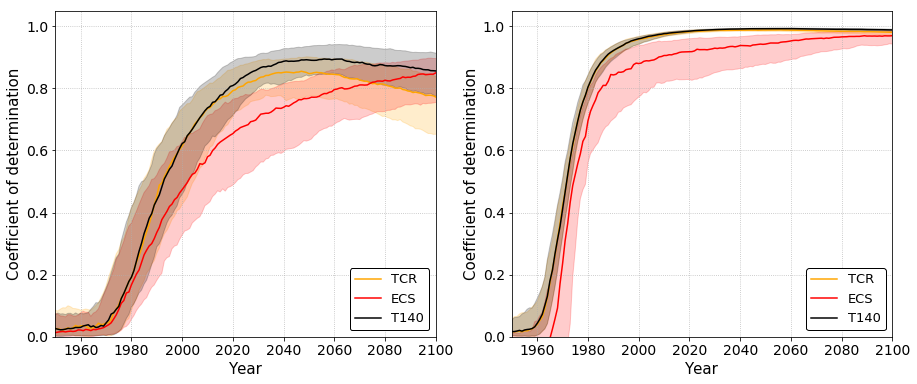

In [19]:
fig_r2, ax_r2 = plt.subplots(1,2,figsize=(15,6))  

ax_r2[0].plot(np.arange(1800,2301), np.median(r_TCRs, axis=1), color='orange', label='TCR')
ax_r2[0].plot(np.arange(1800,2301), np.median(r_ECSs, axis=1), color='red', label='ECS')
ax_r2[0].plot(np.arange(1800,2301), np.median(r_T140s, axis=1), color='black', label='T140')

ax_r2[1].plot(np.arange(1800,2301), np.median(r_TCRs_2, axis=1), color='orange', label='TCR')
ax_r2[1].plot(np.arange(1800,2301), np.median(r_ECSs_2, axis=1), color='red', label='ECS')
ax_r2[1].plot(np.arange(1800,2301), np.median(r_T140s_2, axis=1), color='black', label='T140')
                     
ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_TCRs, 17, axis=1), np.percentile(r_TCRs, 83, axis=1), color='orange', alpha=0.2)
ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_ECSs, 17, axis=1), np.percentile(r_ECSs, 83, axis=1), color='red', alpha=0.2)
ax_r2[0].fill_between(np.arange(1800,2301), np.percentile(r_T140s, 17, axis=1), np.percentile(r_T140s, 83, axis=1), color='black', alpha=0.2)

ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_TCRs_2, 17, axis=1), np.percentile(r_TCRs_2, 83, axis=1), color='orange', alpha=0.2)
ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_ECSs_2, 17, axis=1), np.percentile(r_ECSs_2, 83, axis=1), color='red', alpha=0.2)
ax_r2[1].fill_between(np.arange(1800,2301), np.percentile(r_T140s_2, 17, axis=1), np.percentile(r_T140s_2, 83, axis=1), color='black', alpha=0.2)  

ax_r2[0].set_xlabel('Year', fontsize=15)
ax_r2[0].set_ylabel('Coefficient of determination', fontsize=15)
ax_r2[0].tick_params(labelsize=14)
ax_r2[0].legend(loc='lower right', framealpha = 1.0, edgecolor='black', fontsize=13)
ax_r2[0].grid(True, linestyle=':', alpha=0.9)
ax_r2[0].set_xlim(1950,2100)
ax_r2[0].set_ylim(0,1.05)

ax_r2[1].set_xlabel('Year', fontsize=15)
ax_r2[1].set_ylabel('Coefficient of determination', fontsize=15)
ax_r2[1].tick_params(labelsize=14)
ax_r2[1].legend(loc='lower right', framealpha = 1.0, edgecolor='black', fontsize=13)
ax_r2[1].grid(True, linestyle=':', alpha=0.9)
ax_r2[1].set_xlim(1950,2100)
ax_r2[1].set_ylim(0,1.05)

# fig_r2.savefig('r2_development_over_time_RCP3PD.pdf',dpi=300)

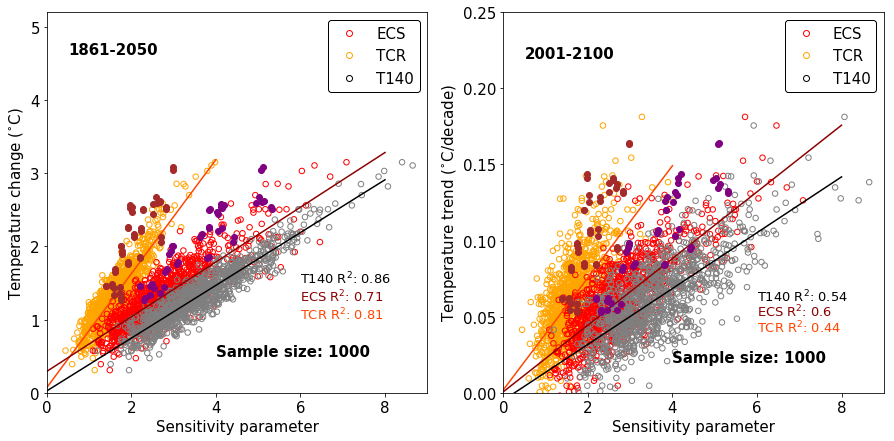

In [17]:
tcrs_junichi = pd.read_csv('./Junichi tuned CMIP6/TCRs_CMIP6_tuned_junichi.csv')
ecss_junichi = pd.read_csv('./Junichi tuned CMIP6/ECSs_CMIP6_tuned_junichi.csv')
T_rcps_junichi = pd.read_csv('./Junichi tuned CMIP6/RCP_temp_resp_CMIP6_tuned_junichi.csv')

fig_1_n_subset,ax_1_n_subset = plt.subplots(1,2,figsize=(15,7)) 
# print(T_rcps_junichi)

# print(tcrs_junichi[tcrs_junichi.Model == T_rcps_junichi['3PD.1'].values[1]])

# print(np.float(T_rcps_junichi['45.1'].values[3:][2040-1765]))

for i in T_rcps_junichi.keys():
    if '3PD' in i:
        T_array = T_rcps_junichi[i].values[3:]
        
        model_name = T_rcps_junichi[i].values[1]
        
        tcr_val = tcrs_junichi[tcrs_junichi.Model == T_rcps_junichi[i].values[1]].TCR
        ecs_val = ecss_junichi[ecss_junichi.Model == T_rcps_junichi[i].values[1]].ECS
        
        T_2050 = 0.0
        T_1861 = 0.0
        T_2001 = 0.0
        T_2100 = 0.0
        for j in range(0,21):
            T_2050 += np.float(T_array[2040+j-1765])/21
            T_1861 += np.float(T_array[1851+j-1765])/21
            T_2001 += np.float(T_array[1991+j-1765])/21
            T_2100 += np.float(T_array[2090+j-1765])/21
        
        delta_T_1861_2050 = T_2050 - T_1861
        delta_T_2001_2100 = T_2100 - T_2001
                                    
        ax_1_n_subset[0].scatter(tcr_val, delta_T_1861_2050, color='brown', zorder=10)
        ax_1_n_subset[0].scatter(ecs_val, delta_T_1861_2050, color='purple', zorder=10)
                                    
        ax_1_n_subset[1].scatter(tcr_val, delta_T_2001_2100/10, color='brown', zorder=10)
        ax_1_n_subset[1].scatter(ecs_val, delta_T_2001_2100/10, color='purple', zorder=10)
        
        



ECS_array_in = np.genfromtxt('1000_ECS_array_rcp3.txt')
ECS_array_in += np.random.normal(0.0,0.1,num)
TCR_array_in = TCR_vals_for_plot

n_subset = 1000

T_difference_1861_2050_subset = T_array_Rolling20YrCentredMean[:n_subset,2050-1765] - T_array_Rolling20YrCentredMean[:n_subset,1861-1765]
T_difference_2001_2100_subset = T_array_Rolling20YrCentredMean[:n_subset,2100-1765] - T_array_Rolling20YrCentredMean[:n_subset,2001-1765]



def fit_line(x,a,b):
    return a*x + b
    
popt1, pcov1 = curve_fit(fit_line, TCR_array_in[:n_subset], T_difference_1861_2050_subset)
popt2, pcov2 = curve_fit(fit_line, TCR_array_in[:n_subset], T_difference_2001_2100_subset/10)
popt3, pcov3 = curve_fit(fit_line, ECS_array_in[:n_subset], T_difference_1861_2050_subset)
popt4, pcov4 = curve_fit(fit_line, ECS_array_in[:n_subset], T_difference_2001_2100_subset/10)

popt5, pcov5 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_1861_2050_subset)
popt6, pcov6 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_2001_2100_subset/10)



var_total_1861_2050 = np.sum((T_difference_1861_2050_subset - np.mean(T_difference_1861_2050_subset))**2)
var_explained_1861_2050_tcr = np.sum((T_difference_1861_2050_subset - popt1[0]*TCR_array_in[:n_subset] - popt1[1])**2)
var_explained_1861_2050_ecs = np.sum((T_difference_1861_2050_subset - popt3[0]*ECS_array_in[:n_subset] - popt3[1])**2)
var_explained_1861_2050_t140 = np.sum((T_difference_1861_2050_subset - popt5[0]*T140_for_plot[:n_subset] - popt5[1])**2)
r_squared_1861_2050_tcr = 1 - (var_explained_1861_2050_tcr / var_total_1861_2050)
r_squared_1861_2050_ecs = 1 - (var_explained_1861_2050_ecs / var_total_1861_2050)
r_squared_1861_2050_t140 = 1 - (var_explained_1861_2050_t140 / var_total_1861_2050)

var_total_2001_2100 = np.sum((T_difference_2001_2100_subset/10 - np.mean(T_difference_2001_2100_subset/10))**2)
var_explained_2001_2100_tcr = np.sum((T_difference_2001_2100_subset/10 - popt2[0]*TCR_array_in[:n_subset] - popt2[1])**2)
var_explained_2001_2100_ecs = np.sum((T_difference_2001_2100_subset/10 - popt4[0]*ECS_array_in[:n_subset] - popt4[1])**2)
var_explained_2001_2100_t140 = np.sum((T_difference_2001_2100_subset/10 - popt6[0]*T140_for_plot[:n_subset] - popt6[1])**2)
r_squared_2001_2100_tcr = 1 - (var_explained_2001_2100_tcr / var_total_2001_2100)
r_squared_2001_2100_ecs = 1 - (var_explained_2001_2100_ecs / var_total_2001_2100)
r_squared_2001_2100_t140 = 1 - (var_explained_2001_2100_t140 / var_total_2001_2100)

ax_1_n_subset[0].text(6,1,'TCR R$^2$: '+str(np.round(r_squared_1861_2050_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[0].text(6,1.25,'ECS R$^2$: '+str(np.round(r_squared_1861_2050_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[0].text(6,1.5,'T140 R$^2$: '+str(np.round(r_squared_1861_2050_t140,2)), color='black', fontsize=13)

ax_1_n_subset[1].text(6,0.04,'TCR R$^2$: '+str(np.round(r_squared_2001_2100_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[1].text(6,0.05,'ECS R$^2$: '+str(np.round(r_squared_2001_2100_ecs,2)), color='darkred', fontsize=13)
ax_1_n_subset[1].text(6,0.06,'T140 R$^2$: '+str(np.round(r_squared_2001_2100_t140,2)), color='black', fontsize=13)








p1 = ax_1_n_subset[0].scatter(TCR_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='orange', label='TCR')
p2 = ax_1_n_subset[1].scatter(TCR_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='orange')

p1 = ax_1_n_subset[0].scatter(ECS_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='red', label='ECS')
p2 = ax_1_n_subset[1].scatter(ECS_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='red')

p1 = ax_1_n_subset[0].scatter(T140_for_plot[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='grey', label='T140')
p2 = ax_1_n_subset[1].scatter(T140_for_plot[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='grey')

ax_1_n_subset[0].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[0].set_ylabel('Temperature change ($^{\circ}$C)',fontsize=15)
ax_1_n_subset[1].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[1].set_ylabel('Temperature trend ($^{\circ}$C/decade)',fontsize=15)
ax_1_n_subset[0].tick_params(labelsize=15)
ax_1_n_subset[1].tick_params(labelsize=15)
ax_1_n_subset[0].text(4.0,0.5,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(4.0,0.02,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[0].text(0.5,5.2*0.8/0.9,'1861-2050',fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(0.5,0.22,'2001-2100',fontsize=15,fontweight='bold')
ax_1_n_subset[0].set_xlim(0,9)
ax_1_n_subset[1].set_xlim(0,9)
ax_1_n_subset[0].set_ylim(0,5.2)
ax_1_n_subset[1].set_ylim(0,0.25)
# ax_1_n_subset[0].legend('best', edgecolor='none', framealpha=0.0)


ax_1_n_subset[0].plot(np.arange(0,5),np.arange(0,5)*popt1[0] + popt1[1], color='orangered')
ax_1_n_subset[1].plot(np.arange(0,5),np.arange(0,5)*popt2[0] + popt2[1], color='orangered')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt3[0] + popt3[1], color='darkred')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt4[0] + popt4[1], color='darkred')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt5[0] + popt5[1], color='black')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt6[0] + popt6[1], color='black')

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='red', color='none', label='ECS', markersize=6, markerfacecolor='none'),
                  Line2D([0], [0], marker='o', markeredgecolor='orange', color='none', label='TCR', markerfacecolor='none', markersize=6),
                  Line2D([0], [0], marker='o', markeredgecolor='black', color='none', label='T140', markerfacecolor='none', markersize=6)]

ax_1_n_subset[0].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)
ax_1_n_subset[1].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)



# fig_1_n_subset.savefig('tcr_t140_ecs_comparison_rsquared.pdf',dpi=300)

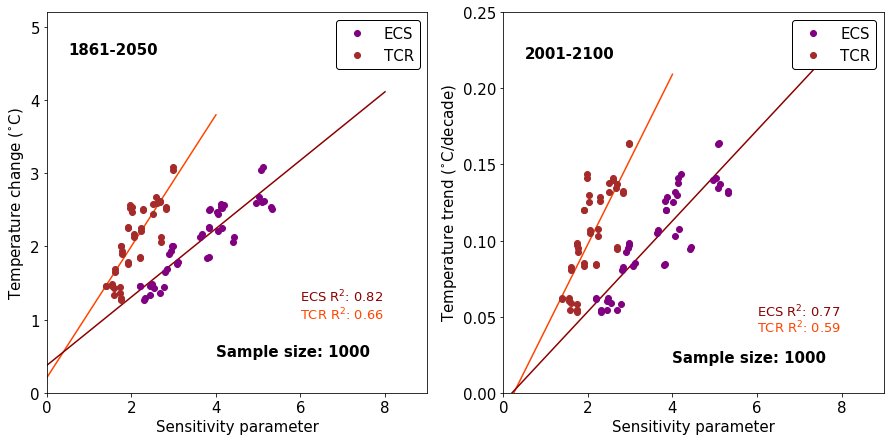

In [16]:
tcr_values_for_plot = np.array([])
ecs_values_for_plot = np.array([])
delta_2050_for_plot = np.array([])
delta_2100_for_plot = np.array([])

fig_1_n_subset,ax_1_n_subset = plt.subplots(1,2,figsize=(15,7)) 
# print(T_rcps_junichi)

# print(tcrs_junichi[tcrs_junichi.Model == T_rcps_junichi['3PD.1'].values[1]])

# print(np.float(T_rcps_junichi['45.1'].values[3:][2040-1765]))

for i in T_rcps_junichi.keys():
    if '3PD' in i:
        T_array = T_rcps_junichi[i].values[3:]
        
        model_name = T_rcps_junichi[i].values[1]
        
        tcr_val = tcrs_junichi[tcrs_junichi.Model == T_rcps_junichi[i].values[1]].TCR
        ecs_val = ecss_junichi[ecss_junichi.Model == T_rcps_junichi[i].values[1]].ECS
        
        T_2050 = 0.0
        T_1861 = 0.0
        T_2001 = 0.0
        T_2100 = 0.0
        for j in range(0,21):
            T_2050 += np.float(T_array[2040+j-1765])/21
            T_1861 += np.float(T_array[1851+j-1765])/21
            T_2001 += np.float(T_array[1991+j-1765])/21
            T_2100 += np.float(T_array[2090+j-1765])/21
        
        delta_T_1861_2050 = T_2050 - T_1861
        delta_T_2001_2100 = T_2100 - T_2001
                                    
        ax_1_n_subset[0].scatter(tcr_val, delta_T_1861_2050, color='brown', zorder=10)
        ax_1_n_subset[0].scatter(ecs_val, delta_T_1861_2050, color='purple', zorder=10)
                                    
        ax_1_n_subset[1].scatter(tcr_val, delta_T_2001_2100/10, color='brown', zorder=10)
        ax_1_n_subset[1].scatter(ecs_val, delta_T_2001_2100/10, color='purple', zorder=10)
        
        tcr_values_for_plot = np.append(tcr_values_for_plot, tcr_val)
        ecs_values_for_plot = np.append(ecs_values_for_plot, ecs_val)
        delta_2050_for_plot = np.append(delta_2050_for_plot, delta_T_1861_2050)
        delta_2100_for_plot = np.append(delta_2100_for_plot, delta_T_2001_2100)
        
        



# ECS_array_in = np.genfromtxt('1000_ECS_array_rcp85.txt')
# ECS_array_in += np.random.normal(0.0,0.1,num)
# TCR_array_in = TCR_vals_for_plot

# n_subset = 1000

# T_difference_1861_2050_subset = T_array_Rolling20YrCentredMean[:n_subset,2050-1765] - T_array_Rolling20YrCentredMean[:n_subset,1861-1765]
# T_difference_2001_2100_subset = T_array_Rolling20YrCentredMean[:n_subset,2100-1765] - T_array_Rolling20YrCentredMean[:n_subset,2001-1765]



def fit_line(x,a,b):
    return a*x + b
    
popt1, pcov1 = curve_fit(fit_line, tcr_values_for_plot, delta_2050_for_plot)
popt2, pcov2 = curve_fit(fit_line, tcr_values_for_plot, delta_2100_for_plot/10)
popt3, pcov3 = curve_fit(fit_line, ecs_values_for_plot, delta_2050_for_plot)
popt4, pcov4 = curve_fit(fit_line, ecs_values_for_plot, delta_2100_for_plot/10)

# popt5, pcov5 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_1861_2050_subset)
# popt6, pcov6 = curve_fit(fit_line, T140_for_plot[:n_subset], T_difference_2001_2100_subset/10)



var_total_1861_2050 = np.sum((delta_2050_for_plot - np.mean(delta_2050_for_plot))**2)
var_explained_1861_2050_tcr = np.sum((delta_2050_for_plot - popt1[0]*tcr_values_for_plot - popt1[1])**2)
var_explained_1861_2050_ecs = np.sum((delta_2050_for_plot - popt3[0]*ecs_values_for_plot - popt3[1])**2)
# var_explained_1861_2050_t140 = np.sum((delta_2050_for_plot - popt5[0]*T140_for_plot[:n_subset] - popt5[1])**2)
r_squared_1861_2050_tcr = 1 - (var_explained_1861_2050_tcr / var_total_1861_2050)
r_squared_1861_2050_ecs = 1 - (var_explained_1861_2050_ecs / var_total_1861_2050)
# r_squared_1861_2050_t140 = 1 - (var_explained_1861_2050_t140 / var_total_1861_2050)

var_total_2001_2100 = np.sum((delta_2100_for_plot/10 - np.mean(delta_2100_for_plot/10))**2)
var_explained_2001_2100_tcr = np.sum((delta_2100_for_plot/10 - popt2[0]*tcr_values_for_plot - popt2[1])**2)
var_explained_2001_2100_ecs = np.sum((delta_2100_for_plot/10 - popt4[0]*ecs_values_for_plot - popt4[1])**2)
# var_explained_2001_2100_t140 = np.sum((delta_2100_for_plot/10 - popt6[0]*T140_for_plot[:n_subset] - popt6[1])**2)
r_squared_2001_2100_tcr = 1 - (var_explained_2001_2100_tcr / var_total_2001_2100)
r_squared_2001_2100_ecs = 1 - (var_explained_2001_2100_ecs / var_total_2001_2100)
# r_squared_2001_2100_t140 = 1 - (var_explained_2001_2100_t140 / var_total_2001_2100)

ax_1_n_subset[0].text(6,1,'TCR R$^2$: '+str(np.round(r_squared_1861_2050_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[0].text(6,1.25,'ECS R$^2$: '+str(np.round(r_squared_1861_2050_ecs,2)), color='darkred', fontsize=13)
# ax_1_n_subset[0].text(6,1.5,'T140 R$^2$: '+str(np.round(r_squared_1861_2050_t140,2)), color='black', fontsize=13)

ax_1_n_subset[1].text(6,0.04,'TCR R$^2$: '+str(np.round(r_squared_2001_2100_tcr,2)), color='orangered', fontsize=13)
ax_1_n_subset[1].text(6,0.05,'ECS R$^2$: '+str(np.round(r_squared_2001_2100_ecs,2)), color='darkred', fontsize=13)
# ax_1_n_subset[1].text(6,0.06,'T140 R$^2$: '+str(np.round(r_squared_2001_2100_t140,2)), color='black', fontsize=13)







# p1 = ax_1_n_subset[0].scatter(TCR_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='orange', label='TCR')
# p2 = ax_1_n_subset[1].scatter(TCR_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='orange')

# p1 = ax_1_n_subset[0].scatter(ECS_array_in[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='red', label='ECS')
# p2 = ax_1_n_subset[1].scatter(ECS_array_in[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='red')

# p1 = ax_1_n_subset[0].scatter(T140_for_plot[:n_subset], T_difference_1861_2050_subset, s=30, facecolors='none', color='grey', label='T140')
# p2 = ax_1_n_subset[1].scatter(T140_for_plot[:n_subset], T_difference_2001_2100_subset/10, s=30, facecolors='none', color='grey')

ax_1_n_subset[0].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[0].set_ylabel('Temperature change ($^{\circ}$C)',fontsize=15)
ax_1_n_subset[1].set_xlabel('Sensitivity parameter',fontsize=15)
ax_1_n_subset[1].set_ylabel('Temperature trend ($^{\circ}$C/decade)',fontsize=15)
ax_1_n_subset[0].tick_params(labelsize=15)
ax_1_n_subset[1].tick_params(labelsize=15)
ax_1_n_subset[0].text(4.0,0.5,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(4.0,0.02,'Sample size: '+str(n_subset),fontsize=15,fontweight='bold')
ax_1_n_subset[0].text(0.5,5.2*0.8/0.9,'1861-2050',fontsize=15,fontweight='bold')
ax_1_n_subset[1].text(0.5,0.22,'2001-2100',fontsize=15,fontweight='bold')
ax_1_n_subset[0].set_xlim(0,9)
ax_1_n_subset[1].set_xlim(0,9)
ax_1_n_subset[0].set_ylim(0,5.2)
ax_1_n_subset[1].set_ylim(0,0.25)
# ax_1_n_subset[0].legend('best', edgecolor='none', framealpha=0.0)


ax_1_n_subset[0].plot(np.arange(0,5),np.arange(0,5)*popt1[0] + popt1[1], color='orangered')
ax_1_n_subset[1].plot(np.arange(0,5),np.arange(0,5)*popt2[0] + popt2[1], color='orangered')

ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt3[0] + popt3[1], color='darkred')
ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt4[0] + popt4[1], color='darkred')

# ax_1_n_subset[0].plot(np.arange(0,9),np.arange(0,9)*popt5[0] + popt5[1], color='black')
# ax_1_n_subset[1].plot(np.arange(0,9),np.arange(0,9)*popt6[0] + popt6[1], color='black')

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='purple', color='none', label='ECS', markersize=6, markerfacecolor='purple'),
                  Line2D([0], [0], marker='o', markeredgecolor='brown', color='none', label='TCR', markerfacecolor='brown', markersize=6),]
#                   Line2D([0], [0], marker='o', markeredgecolor='black', color='none', label='T140', markerfacecolor='none', markersize=6)]

ax_1_n_subset[0].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)
ax_1_n_subset[1].legend(handles=legend_elements, loc='upper right', edgecolor='black', framealpha=1.0, fontsize=15)



# fig_1_n_subset.savefig('tcr_t140_ecs_comparison_rsquared.pdf',dpi=300)